In [1]:
%matplotlib inline
import itertools
import numpy as np
import time
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter

plt.style.use("ggplot")

# for reproducibility of this notebook:
rng = np.random.RandomState(123)
tf.random.set_seed(42)

In [2]:
def func(x):
    return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)


N = 10000  # Number of training observations

X = rng.rand(N, 1) * 2 - 1  # X values
Y = func(X) + 0.2 * rng.randn(N, 1)  # Noisy Y values
data = (X, Y)

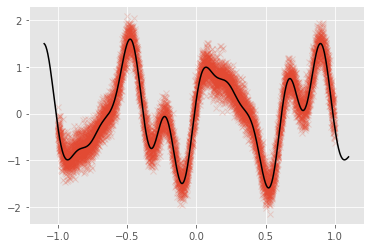

In [3]:
plt.plot(X, Y, "x", alpha=0.2)
Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
Yt = func(Xt)
_ = plt.plot(Xt, Yt, c="k")

In [4]:
M = 50  # Number of inducing locations

kernel = gpflow.kernels.SquaredExponential()
Z = X[:M, :].copy()  # Initialize inducing locations to the first M inputs in the dataset

m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)

In [6]:
minibatch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)

train_iter = iter(train_dataset.batch(minibatch_size))

ground_truth = elbo(tensor_data).numpy()

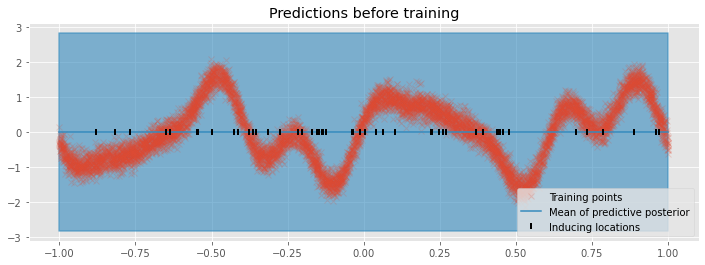

In [7]:
def plot(title=""):
    plt.figure(figsize=(12, 4))
    plt.title(title)
    pX = np.linspace(-1, 1, 100)[:, None]  # Test locations
    pY, pYv = m.predict_y(pX)  # Predict Y values at test locations
    plt.plot(X, Y, "x", label="Training points", alpha=0.2)
    (line,) = plt.plot(pX, pY, lw=1.5, label="Mean of predictive posterior")
    col = line.get_color()
    plt.fill_between(
        pX[:, 0],
        (pY - 2 * pYv ** 0.5)[:, 0],
        (pY + 2 * pYv ** 0.5)[:, 0],
        color=col,
        alpha=0.6,
        lw=1.5,
    )
    Z = m.inducing_variable.Z.numpy()
    plt.plot(Z, np.zeros_like(Z), "k|", mew=2, label="Inducing locations")
    plt.legend(loc="lower right")


plot(title="Predictions before training")

In [8]:
minibatch_size = 100

# We turn off training for inducing point locations
gpflow.set_trainable(m.inducing_variable, False)


def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

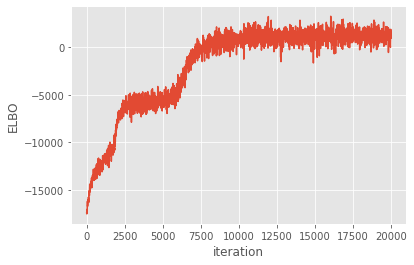

In [9]:
maxiter = ci_niter(20000)

logf = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

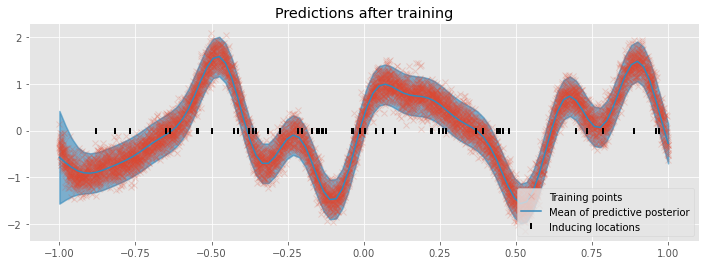

In [10]:
plot("Predictions after training")

In [23]:
for i in range(1):
    a = train_iter.__next__()

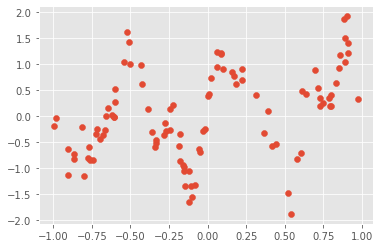

In [29]:
plt.scatter(*a)

In [30]:
a

(<tf.Tensor: shape=(100, 1), dtype=float64, numpy=
 array([[ 0.15676173],
        [ 0.60245412],
        [ 0.58039697],
        [-0.1552484 ],
        [-0.07899748],
        [-0.61808799],
        [-0.33757982],
        [ 0.72634202],
        [-0.43491931],
        [ 0.71294841],
        [ 0.85407979],
        [ 0.97541689],
        [-0.79843853],
        [-0.15943457],
        [ 0.00112284],
        [ 0.63519   ],
        [-0.66383271],
        [-0.50087623],
        [-0.77313883],
        [ 0.39262254],
        [-0.10342792],
        [ 0.8829179 ],
        [-0.12041938],
        [-0.36347348],
        [ 0.08513426],
        [-0.05544808],
        [-0.76867315],
        [ 0.72527562],
        [-0.24515095],
        [ 0.5232419 ],
        [ 0.18433828],
        [ 0.78464571],
        [ 0.86023705],
        [-0.71995418],
        [-0.60228025],
        [-0.67920756],
        [-0.72261928],
        [ 0.00731101],
        [ 0.79645052],
        [-0.28404519],
        [-0.11844912],
      

(array([ 985., 1079.,  991.,  938.,  972., 1020., 1010., 1048., 1002.,
         955.]),
 array([-9.99864323e-01, -7.99899878e-01, -5.99935433e-01, -3.99970988e-01,
        -2.00006542e-01, -4.20971417e-05,  1.99922348e-01,  3.99886793e-01,
         5.99851239e-01,  7.99815684e-01,  9.99780129e-01]),
 <BarContainer object of 10 artists>)

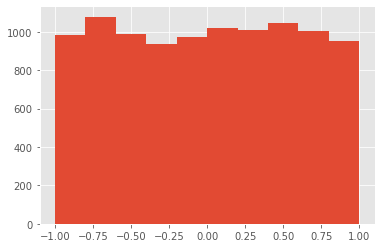

In [32]:
plt.hist(X)